# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified national model (google)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns,pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD_google
from covid19model.models.time_dependant_parameter_fncs import google_lockdown
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator 
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load data

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-08,6955,1470,403,295,5669,204,1.0,11.0,29,55,107
2020-11-09,7221,1474,434,145,5958,185,0.0,13.0,25,58,89
2020-11-10,7058,1470,609,708,5859,163,1.0,15.0,21,47,78
2020-11-11,6879,1463,544,626,5777,121,1.0,10.0,15,46,49
2020-11-12,7010,1452,399,242,5934,19,0.0,2.0,3,5,9


### Scrape Google Community Mobility Reports

In [4]:
df_google = google.get_google_mobility_data(update=False, plot=False)

### Load time-dependant parameters

In [5]:
from covid19model.models.time_dependant_parameter_fncs import google_lockdown

def switch_beta(t,param,samples_dict):
    if t < pd.to_datetime('2020-05-04'):
        return np.random.choice(samples_dict['beta'],1,replace=False)
    elif pd.to_datetime('2020-05-04') < t <= pd.to_datetime('2020-09-01'):
        return np.random.choice(samples_dict['beta_summer'],1,replace=False)
    else:
        return np.random.choice(samples_dict['beta'],1,replace=False)

# Wave 1 - March 2020 - September 2020

### Initialize the model using the google lockdown function

In [6]:
# Load samples dictionary of the first wave
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-05.json', 'r') as fp:
    samples_dict = json.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-05.json'

In [7]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [8]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

In [9]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
              })

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown})

ValueError: The specified parameters don't exactly match the predefined parameters. Redundant parameters: set(). Missing parameters: {'prevention'}

## Perform calibration

In [10]:
# Date of first data collection
start_data = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_calibration = '2020-05-04'
# Start of recalibration beta
start_recalibrate_beta = end_calibration
# End of recalibration beta
end_recalibrate_beta = '2020-09-01'

# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE'

In [11]:
from covid19model.optimization.run_optimization import google_calibration_wave1
samples_dict = google_calibration_wave1(model, df_sciensano['H_in'], spatial_unit, start_data, end_calibration, start_recalibrate_beta,
                        end_recalibrate_beta, fig_path, 
                        samples_path, initN, Nc_total,warmup=samples_dict['warmup'],maxiter=100, popsize=100, steps_mcmc=5000,
                        discard=1000, omega=0.8, phip=0.8, phig=0.8)

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-03-15 until 2020-05-04

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 2: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 3: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 4: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 5: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 6: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 7: [5.35585457e+01 3.94388337e-02 2.59344208e+00 9.71727058e+00] 232.44399047050274
Best after iteration 8: [5.35585457e+01 3.94388337e-02

New best for swarm at iteration 58: [5.56717801e+01 3.93170841e-02 2.48464870e+00 9.78051641e+00] 230.52659005063893
Best after iteration 58: [5.56717801e+01 3.93170841e-02 2.48464870e+00 9.78051641e+00] 230.52659005063893
Best after iteration 59: [5.56717801e+01 3.93170841e-02 2.48464870e+00 9.78051641e+00] 230.52659005063893
New best for swarm at iteration 60: [5.56495430e+01 3.93179865e-02 2.48288486e+00 9.78054167e+00] 230.52652047020078
Best after iteration 60: [5.56495430e+01 3.93179865e-02 2.48288486e+00 9.78054167e+00] 230.52652047020078
New best for swarm at iteration 61: [5.57122105e+01 3.93177830e-02 2.48404682e+00 9.77541481e+00] 230.52646865823382
Best after iteration 61: [5.57122105e+01 3.93177830e-02 2.48404682e+00 9.77541481e+00] 230.52646865823382
Best after iteration 62: [5.57122105e+01 3.93177830e-02 2.48404682e+00 9.77541481e+00] 230.52646865823382
New best for swarm at iteration 63: [5.57210421e+01 3.93193550e-02 2.48310684e+00 9.77715024e+00] 230.52633466718697
Be

100%|██████████| 5000/5000 [3:16:39<00:00,  2.36s/it]  



3) Saving chains


4) Computing R0

------------------
RECALIBRATING BETA
------------------

Using data from 2020-05-04 until 2020-09-01

1) Computing model states on 2020-05-04
2) Re-initialize model on 2020-05-04
3) Particle swarm optimization

No constraints given.
New best for swarm at iteration 1: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 1: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 2: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 3: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 4: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 5: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 6: [12.87368946  0.03096612] 353.95888713985113
Best after iteration 7: [12.87368946  0.03096612] 353.95888713985113
New best for swarm at iteration 8: [10.42318638  0.03089838] 351.19792502931784
Best after iteration 8: [10.42318638  0.03089838] 351.19792502931784
New best for swar

Best after iteration 100: [10.77085017  0.03036178] 348.08229245775937
Stopping search: maximum iterations reached --> 100

4) Markov-Chain Monte-Carlo sampling



100%|██████████| 5000/5000 [3:17:45<00:00,  2.37s/it]  



5) Saving chains

-------------------------------------
COMPUTING MODEL STATES ON 2020-09-01
-------------------------------------

1) Initializing COVID-19 SEIRD

2) Simulating COVID-19 SEIRD 30 times

from 2020-03-15 until 2020-09-01

3) Dumping results

DONE

SAMPLES DICTIONARY SAVED IN "../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-10_WAVE1_GOOGLE.json"



## Visualizations

### Goodness-of-fit: $\beta$, $l$ and $\tau$

In [12]:
params.update({'samples_dict': samples_dict})

# Re-initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown, 'beta': switch_beta})

<ipython-input-13-ee399c2b1280>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/BETA_RAMP_FIT_WAVE1_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


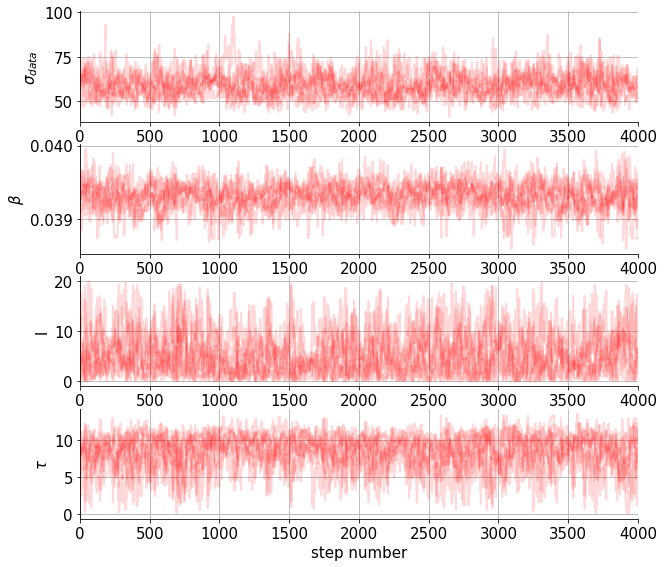

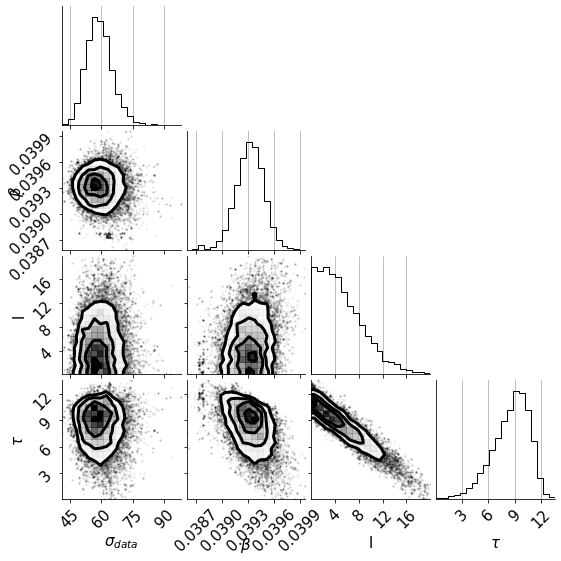

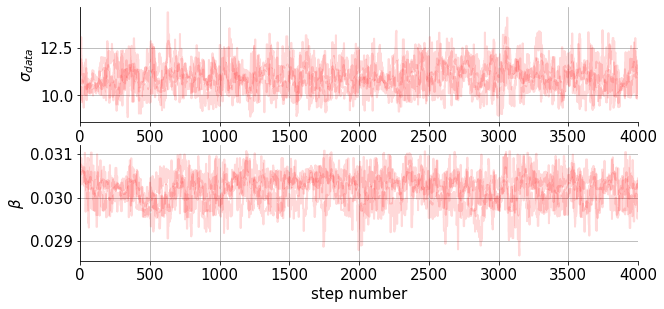

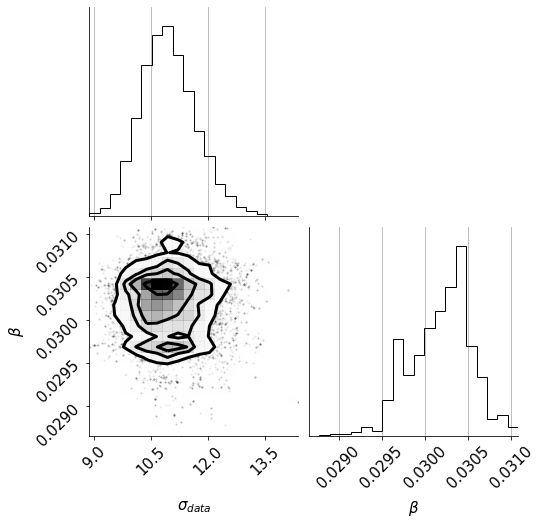

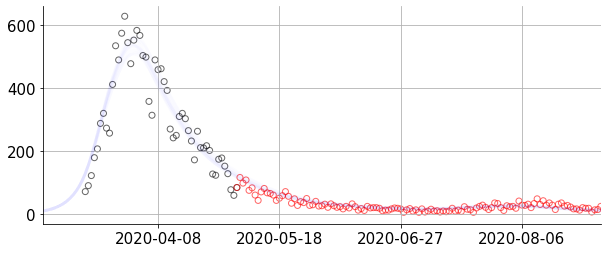

In [13]:
end_sim = '2020-09-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    model.parameters = draw_sample_COVID19_SEIRD_google(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_data,excess_time=samples_dict['warmup'])
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[:end_calibration].index,df_sciensano['H_in'][:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax.scatter(df_sciensano[end_calibration:end_sim].index,df_sciensano['H_in'][end_calibration:end_sim],color='red',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-01',end_sim)

plt.savefig(fig_path+'others/BETA_RAMP_FIT_WAVE1_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### $R_0$

<ipython-input-14-b58c7d2ce12c>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/R0_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


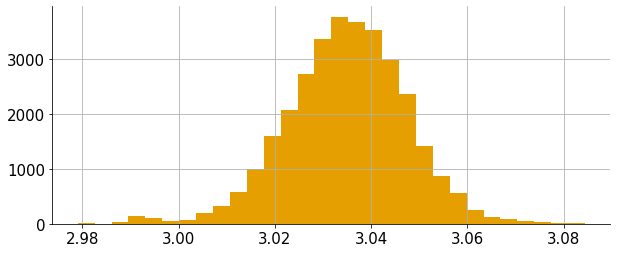

In [14]:
fig,ax=plt.subplots(figsize=(10,4))
ax.hist(samples_dict['R0'],bins=30)
plt.savefig(fig_path+'others/R0_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Seroprelevance

<ipython-input-15-2f45ae09591a>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/SEROPRELEVANCE_'+end_sim+'_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


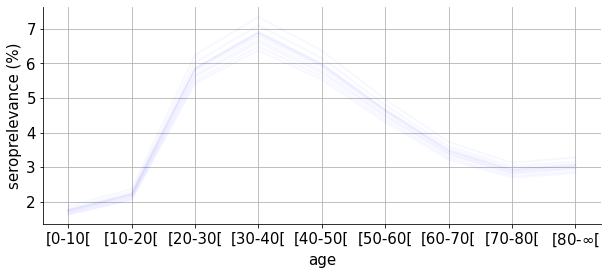

In [15]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    model.parameters = draw_sample_COVID19_SEIRD_google(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_data,excess_time=samples_dict['warmup'])
    ax.plot((1-y_model["S"].sel(time=end_sim)/y_model["S"].isel(time=0))*100,alpha=0.03,color='blue',linewidth=2)

ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
ax.set_ylim()
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

plt.savefig(fig_path+'others/SEROPRELEVANCE_'+end_sim+'_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Lockdown release

<ipython-input-16-cdf6c3e9bdc7>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/LOCKDOWN_RELEASE_WAVE1_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


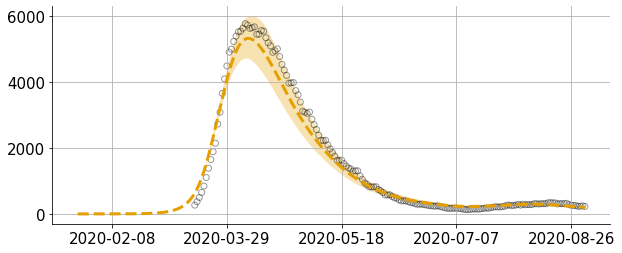

In [16]:
end_sim = '2020-09-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_data,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD_google,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/LOCKDOWN_RELEASE_WAVE1_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Save results to a .csv

In [17]:
index = y_model['time'].values
columns = ['WAVE1_INCIDENCES_MEAN','WAVE1_INCIDENCES_MEDIAN','WAVE1_INCIDENCES_LL','WAVE1_INCIDENCES_UL']
data = np.transpose(np.array([
        y_model["H_tot"].mean(dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].median(dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc").values.tolist()
       ]))

In [18]:
df = pd.DataFrame(data,columns=columns,index=index)
df.head()

,WAVE1_INCIDENCES_MEAN,WAVE1_INCIDENCES_MEDIAN,WAVE1_INCIDENCES_LL,WAVE1_INCIDENCES_UL
2020-01-24,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.001501,0.001500,0.001500,0.001501
2020-01-26,0.009643,0.009643,0.009642,0.009644
2020-01-27,0.026477,0.026477,0.026470,0.026483
2020-01-28,0.051716,0.051715,0.051695,0.051733


In [19]:
df.to_csv('../../results/predictions/FAGG/COVID19_SEIRD/WAVE1.csv',index=True)

# Wave 2: September 2020 - present

## Recalibrate ramp as final calibration step

In [10]:
# Load samples dictionary of the first wave
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/BE_2020-11-10_WAVE1_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    

In [11]:
# Start of data collection
start_data = '2020-09-01'
# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to recalibrate the ramp
end_calibration = '2020-11-07'
# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE'

In [12]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention': 0.8
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown})

In [ ]:
warmup=0
maxiter = 50
popsize = 50
steps_mcmc = 1000
discard = 500

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau','prevention']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),(0,1))
# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,start_date=start_calibration,warmup=warmup)

# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),(0,1))

pos = theta + [1, 1e-3, 1e-3, 1e-3, 1e-3 ]* np.random.randn(10, 5)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

try:
    sampler.get_autocorr_time()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler.get_chain(discard=discard,flat=False), sampler.get_chain(discard=discard,flat=True), fig_path, spatial_unit, 
            figname='BETA_RAMP_GOOGLE_WAVE2', labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$'])

#############################################
####### Output to dictionary ################
#############################################

samples_dict_wave2 = {
    'beta': sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),
    'l' : sampler.get_chain(discard=discard,flat=True)[:,2].tolist(),
    'tau' : sampler.get_chain(discard=discard,flat=True)[:,3].tolist(),
    'prevention': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-09-01 until 2020-11-07

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [2.04222331e+02 4.39968509e-02 2.55348323e+00 8.64153688e+00
 5.90971545e-01] 368.7285817131649
Best after iteration 2: [2.04222331e+02 4.39968509e-02 2.55348323e+00 8.64153688e+00
 5.90971545e-01] 368.7285817131649
New best for swarm at iteration 3: [7.72760048e+01 4.27334853e-02 2.69139883e+00 1.00000000e-01
 8.32559692e-01] 360.95468436121
Best after iteration 3: [7.72760048e+01 4.27334853e-02 2.69139883e+00 1.00000000e-01
 8.32559692e-01] 360.95468436121
New best for swarm at iteration 4: [1.64690554e+02 4.40472959e-02 3.96070011e+00 4.76392526e+00
 7.62129224e-01] 351.66970764976537
Best after iteration 4: [1.64690554e+02 4.40472959e-02 3.96070011e+00 4.76392526e+00
 7.62129224e-01] 351.66970764976537
New best for swarm at iteration 5: [8.69363562e+0

New best for swarm at iteration 45: [4.83859567e+01 4.42337011e-02 1.40294707e-01 3.35751317e+00
 8.07885533e-01] 298.6719972714286
Best after iteration 45: [4.83859567e+01 4.42337011e-02 1.40294707e-01 3.35751317e+00
 8.07885533e-01] 298.6719972714286
New best for swarm at iteration 46: [4.93843893e+01 4.42200419e-02 1.77207280e-01 3.42083195e+00
 8.17652377e-01] 298.6474391265158
Best after iteration 46: [4.93843893e+01 4.42200419e-02 1.77207280e-01 3.42083195e+00
 8.17652377e-01] 298.6474391265158
Best after iteration 47: [4.93843893e+01 4.42200419e-02 1.77207280e-01 3.42083195e+00
 8.17652377e-01] 298.6474391265158
Best after iteration 48: [4.93843893e+01 4.42200419e-02 1.77207280e-01 3.42083195e+00
 8.17652377e-01] 298.6474391265158
New best for swarm at iteration 49: [4.87888130e+01 4.42109534e-02 1.72340879e-01 3.47302038e+00
 8.20931931e-01] 298.6441886086562
Best after iteration 49: [4.87888130e+01 4.42109534e-02 1.72340879e-01 3.47302038e+00
 8.20931931e-01] 298.6441886086562

 32%|███▎      | 325/1000 [15:05<33:08,  2.95s/it]

## Visualize fit

<ipython-input-24-042580cc46f0>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/BETA_RAMP_FIT_WAVE2_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


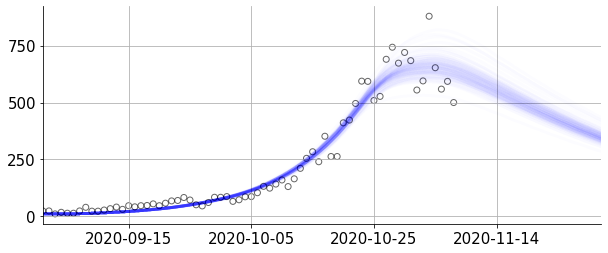

In [24]:
end_sim = '2020-12-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    model.parameters['beta'] = np.random.choice(sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(sampler.get_chain(discard=discard,flat=True)[:,2].tolist())))
    model.parameters['tau'] = sampler.get_chain(discard=discard,flat=True)[:,3].tolist()[idx]    
    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,excess_time=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
plt.savefig(fig_path+'others/BETA_RAMP_FIT_WAVE2_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

## Make a prediction under current contact behaviour

<ipython-input-37-4c6a30fe5ae4>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/LOCKDOWN_WAVE2_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


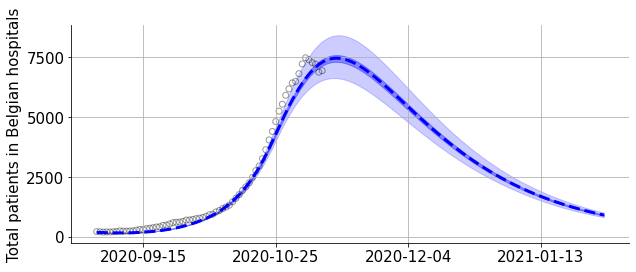

In [37]:
end_sim = '2021-02-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_calibration,excess_time=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD_google,samples=samples_dict_wave2)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-0.68,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(0.68,dim="draws").sum(dim="Nc"),alpha=0.35, color = 'blue')
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_tot'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax.set_ylabel('Total patients in Belgian hospitals')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/LOCKDOWN_WAVE2_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')